In [3]:
!pip -q install towhee towhee.models

In [4]:
from towhee import pipeline

In [5]:
p = pipeline('image-embedding')

Cloning the repo: towhee/image-embedding-resnet50... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: towhee/image-embedding-resnet50.
Do you want to install ruamel.yaml? [y/n]: y
ruamel.yaml installed successfully!


In [6]:
output = p('https://raw.githubusercontent.com/towhee-io/towhee/main/docs/02-Getting%20Started/towhee.jpeg')

Cloning the repo: towhee/image-decoder... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: towhee/image-decoder.
Cloning the repo: towhee/timm-image-embedding... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: towhee/timm-image-embedding.


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [7]:
output

array([0.05727836, 0.06637038, 0.        , ..., 0.08792703, 0.3107774 ,
       0.        ], dtype=float32)

In [9]:
from towhee import DataCollection

In [10]:
dc = DataCollection.range(5)

In [12]:
(
    dc.map(lambda x: x + 1)
      .map(lambda x: x * 2)
      .to_list()
)

[2, 4, 6, 8, 10]

In [14]:
def is_prime(x):
  if x <=1:
    return False
  for i in range(2, int(x/2)+1):
    if (x%i) == 0:
      return False
  return True


In [15]:
is_prime(5)

True

In [13]:
!pip -q install pandas scikit-learn scikit-learn opencv-python ipython matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [19]:
dc = DataCollection(iter(range(10)))

In [20]:
dc.map(is_prime).to_list() 

[False, False, True, True, False, True, False, True, False, False]

In [21]:
dk = (
    DataCollection.range(10)
      .filter(is_prime)
      .filter(lambda x: x % 10 == 3)
      .map(str)
)

In [22]:
dk.to_list()

['3']

Pythonic Method-Chaining Style API: Designed to behave as a python list or iterator, DataCollection is easy to understand for python users and is compatible with most popular data science toolkits. Function/Operator invocations can be chained one after another, making your code clean and fluent.

Exception-Safe Execution: DataCollection provides exception-safe execution, which allows the function/operator invocation chain to continue executing on exception. Data scientists can put an exception receiver to the tail of the pipeline, processing and analyzing the exceptions as data, not errors.

Feature-Rich Operator Repository: There are various pre-defined operators On the towhee hub, which cover the most popular deep learning models in computer vision, NLP, and voice processing. Using these operators in the data processing pipeline can significantly accelerate your work.

In [27]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  97.8M      0  0:00:01  0:00:01 --:--:--  123M


In [26]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee.dc2 import pipe, ops, DataCollection


# Towhee parameters
MODEL = 'resnet50'
DEVICE = None # if None, use default device (cuda is enabled if available)

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = 'reverse_image_search.csv'
QUERY_SRC = './test/*/*.JPEG'

In [32]:
# Milvus parameters
HOST = 'ec2-52-54-132-59.compute-1.amazonaws.com'
PORT = '19530'
TOPK = 10
DIM = 2048 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'reverse_image_search'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'


In [28]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item

In [29]:
# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

In [30]:
p_display = p_embed.output('img_path', 'img', 'vec')

Cloning the repo: towhee/image-decode... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: towhee/image-decode.
Cloning the repo: image-embedding/timm... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: image-embedding/timm.


Cloning the repo: image-decode/cv2... Be patient and waiting printing 'Successfully'.
Successfully clone the repo: image-decode/cv2.


img_path,img,vec
./test/goldfish/n01443537_3883.JPEG,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

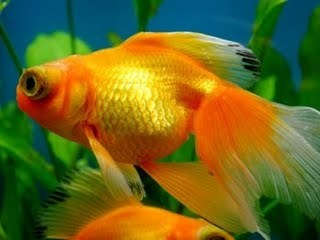

In [31]:
DataCollection(p_display('./test/goldfish/*.JPEG')).show()

In [ ]:
!pip install pymilvus

In [ ]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

In [ ]:
# Insert pipeline
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.))
          .output('mr')
)